In [7]:
import torch
features = {}
def hook_fn(module, input, output):
    features['pre_head'] = output.detach() 
#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Init model

In [ ]:
# load eva02_large_patch14_clip_336 from timm
import timm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "hf_hub:timm/eva02_large_patch14_clip_336.merged2b_ft_inat21"
model = timm.create_model(model_path, pretrained=True)
# model = torch.nn.Sequential(*list(model.children())[:-1]).to(device)
model = model.to(device)

hook_handle = model.norm.register_forward_hook(hook_fn)
model.eval() 

In [2]:
# load ConvNeXt
import torch
from PDDD.Codes.modelpy.visual_model.ConvNeXt import convnext_base

# # Khởi tạo kiến trúc mô hình trước
model = convnext_base(6)

# # Load trọng số đã lưu
model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ConvNeXt.std"
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model=model.to(device)
# model.eval()  # Đặt model ở chế độ inference

In [49]:
# load ViT_L, ViLT
import torch
from PDDD.Codes.modelpy.visual_model.ViT_L import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo kiến trúc mô hình trước
model = VisionTransformer()

# Load trọng số đã lưu
model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ViT_L.std"
# model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ViLT.mdl"
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model=model.to(device)

# hook_handle = classification_head.head[1].register_forward_hook(hook_fn)
ishook = True

# model.eval()  # Đặt model ở chế độ inference

In [8]:
# load ResNet152
import torch
import os
from PDDD.Codes.modelpy.visual_model.ResNet_50_101_152 import ResNet152
from PDDD.Codes.modelpy.visual_model.ViT_L import VisionTransformer

# Khởi tạo kiến trúc mô hình trước
model = ResNet152()

# Load trọng số đã lưu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ResNet152.std"
model.load_state_dict(torch.load(model_path, map_location=device))
model=model.to(device)

hook_handle = model.avgpool.register_forward_hook(hook_fn)
model_name = os.path.basename(model_path)
model.eval()  # Đặt model ở chế độ inference

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (

### Check model layer

In [ ]:
import torch.nn as nn
backbone = nn.Sequential(*list(model.children()))  
backbone

In [ ]:
classification_head = dict(model.named_children())['fc']
classification_head

Linear(in_features=2048, out_features=1024, bias=True)

In [ ]:
print(model.layer4)
print(model.fc)

In [15]:
for name, param in model.named_parameters():
    if name.startswith(('conv1', 'layer1', 'layer2', 'layer3')):
        param.requires_grad = False
    else:
        param.requires_grad = True


num_trainable_params = sum(1 for p in model.parameters() if p.requires_grad)
print(f"Số lượng tensor cần training: {num_trainable_params}")

num_trainable_elements = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Tổng số tham số cần training: {num_trainable_elements}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số tham số       : {total_params:,}")
print(f"Số tham số cần training: {trainable_params:,}")

Số lượng tensor cần training: 32
Tổng số tham số cần training: 17062912
Tổng số tham số       : 60,241,984
Số tham số cần training: 17,062,912


In [ ]:
from torchsummary import summary
model = model.to("cuda" or "cpu")
summary(model, input_size=(3, 224, 224))  # Thay đổi input_size tùy vào model

## Run model

### Read data

In [3]:
# read PDDD anotation
%store -r image_dict
def get_PDDD_info(image_id):
    img_info = image_dict[image_id]
    return img_info["file_name"]

%store -r category_dict
def get_PDDD_category(category_id):
    return category_dict[category_id]

%store -r image_paths labels

# from collections import Counter
# list = Counter(labels)

image_paths[:2], labels[:2], len(image_paths), len(labels)

(['/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomato blight leaf/IMG_20221118_082850_368_jpg.rf.61b5ec99d23a3f0c5a1766e235fb3b6b_1086_Tomato blight leaf.jpg',
  '/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomato blight leaf/IMG_20221118_081723_527_jpg.rf.337930f270075f587a13824248c1e5bd_3814_Tomato blight leaf.jpg'],
 ['Tomato blight leaf', 'Tomato blight leaf'],
 2765,
 2765)

In [10]:
# common utils
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.416, 0.468, 0.355],   # normalize
                         std=[0.210, 0.206, 0.213])
])  # in PDDD paper

###############################    
def load_image(image_path):
    if image_path.startswith('http'):
        # Download image from URL
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        # Load local image
        image = Image.open(image_path).convert('RGB')
    return image

### Predict 

In [ ]:
# run prediction
pred_labels = []
confidences = []
for image_path in tqdm(image_paths[:10]):
    pred_class_id, confidence = predict_plant(image_path)
    # pred_label = get_PDDD_category(pred_class_id)
    pred_labels.append(pred_class_id)
    confidences.append(confidence)

pred_labels[:10], confidences[:10]

In [ ]:
# pretrained utils
def predict_plant(image_path):
    """Predict plant species and return class ID and confidence"""
    image = load_image(image_path)
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        confidence, pred_class = torch.topk(probs, 1)
    return pred_class.item(), confidence.item()

### Embedding

In [11]:
# embedding utils
import torch
from torchvision import models, transforms
from tqdm import tqdm
import faiss
import numpy as np
from PIL import Image

def model_forward(model_name, tensor):
    match model_name:
        case 'ConvNeXt.std' | 'eva02_large_patch14_clip_336.merged2b_ft_inat21':
            return model.forward_features(tensor)

        case _:
            output = model(tensor)
            embedding = features['pre_head']
            return embedding

def get_image_embedding(model, image, device='cuda'):
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model_forward(model_name,img_tensor)  # lấy token embeddingput
        # embedding = torch.nn.functional.normalize(embedding, dim=1)
    return embedding.squeeze(0).cpu().numpy().reshape(1, -1)

def create_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def run_model(image_paths, labels):
    embeddings = []
    for path, label in tqdm(list(zip(image_paths, labels)), desc="Extract embeddings"):  # giới hạn 300 ảnh
        img = Image.open(path).convert("RGB")
        vec = get_image_embedding(model, img)
        embeddings.append(vec)
    labels = labels[:len(embeddings)]
    # hook_handle.remove()  
    return embeddings, labels

# Evaluate
def evaluate(index, labels, embeddings):
    correct = 0
    total = len(labels)
    pred_labels = []
    distances = []
    for i in range(total):
        top1, distance = inference(model,index,embeddings[i],i)
        pred_labels.append(labels[top1])
        distances.append(distance)
        if labels[i] == labels[top1]:
            correct += 1

    accuracy = correct / total
    return accuracy, pred_labels, distances

embeddings,labels = run_model(image_paths, labels)
embeddings_np = np.array(embeddings).astype("float32").squeeze(1)  # FAISS cần float32
index = create_index(embeddings_np)
embeddings_np.shape

Extract embeddings: 100%|██████████| 2765/2765 [01:14<00:00, 37.28it/s]


(2765, 2048)

In [12]:
# Evaluate accuracy
def inference(model,index,embedding, i):
        query_vec = embedding.reshape(1, -1)
        distance, result = index.search(query_vec, k=2)  # i: nearest vector, D: distance
        top1 = result[0][1] if result[0][0] == i else result[0][0]
        # top1 = result[0][0]
        return top1, distance

# Evaluate
def evaluate(index, labels, embeddings):
    correct = 0
    total = len(labels)
    pred_labels = []
    distances = []
    for i in tqdm(range(len(embeddings))):
        top1, distance = inference(model,index,embeddings[i],i)
        pred_labels.append(labels[top1])
        distances.append(distance)
        if labels[i] == labels[top1]:
            correct += 1

    accuracy = correct / len(embeddings)
    return accuracy, pred_labels, distances

accuracy, pred_labels, distances = evaluate(index, labels, embeddings_np)
accuracy, pred_labels[:3], distances[:2]

100%|██████████| 2765/2765 [00:02<00:00, 1003.42it/s]


(0.8491862567811935,
 ['Tomato Brown Spots', 'Tomato blight leaf', 'Tomato blight leaf'],
 [array([[  0.     , 129.12904]], dtype=float32),
  array([[ 0.      , 52.070724]], dtype=float32)])

### Test

In [ ]:
image = load_image('/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd66077d50344a_7246_Corn Smut.jpg')
embedding = get_image_embedding(model,image)
print(embedding.shape)

### File IO

In [4]:
# init path
import os
import faiss
import numpy as np
import json
dir_path = '/media/icnlab/Data/Manh/tinyML/FieldPlant-11'
index_path = os.path.join(dir_path,f'{model_name}_tomatocropped.index')
json_path = os.path.join(dir_path,f'{model_name}_tomatocropped.json')

data_name = os.path.basename(dir_path)

In [ ]:
# save file index
faiss.write_index(index, index_path)

# save class mapping (index -> class_id)
with open(json_path, "w") as f:
    json.dump(labels, f)

size_on_disk = os.path.getsize(index_path) / (1024 * 1024)
print(f"FAISS index file size: {size_on_disk:.2f} MB")
len(labels)

FAISS index file size: 10.88 MB


2786

In [21]:
# Read file index
import faiss
import json
import os
# Đọc index từ file
index = faiss.read_index(index_path)
embeddings_np = index.reconstruct_n(0, index.ntotal)

# Đọc label mapping
with open(json_path, "r") as f:
    labels = json.load(f)  

size_on_disk = os.path.getsize(index_path) / (1024 * 1024)
print(f"FAISS index file size: {size_on_disk:.2f} MB")
model_name,data_name, embeddings_np.shape, len(labels)

FAISS index file size: 10.88 MB


('ConvNeXt.std', 'FieldPlant-11', (2786, 1024), 2786)

In [22]:
# Feature selection
labels_removed = ['Tomato leaf mosaic virus','Tomato bacterial wilt']
for i in range(len(labels) - 1, -1, -1):
    if labels[i] in labels_removed:
        embeddings_np = np.delete(embeddings_np, i, axis=0)
        labels = np.delete(labels, i)

embeddings_np.shape, labels.shape, type(embeddings_np), type(labels)

((2765, 1024), (2765,), numpy.ndarray, numpy.ndarray)

In [23]:
# Clustering metrics 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from collections import Counter
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm

def evaluate_clustering(embeddings, labels):
    # Ensure inputs are numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    # Get number of unique classes for k-means
    k = len(np.unique(labels))
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    pred_clusters = kmeans.fit_predict(embeddings)
    
    # Calculate all metrics
    metrics = {
        'purity': cluster_purity(labels, pred_clusters),
        'ari': adjusted_rand_score(labels, pred_clusters),
        'nmi': normalized_mutual_info_score(labels, pred_clusters),
        'silhouette': silhouette_score(embeddings, pred_clusters)
    }
    
    return metrics, pred_clusters

def cluster_purity(true_labels, cluster_labels):
    cluster_purity_sum = 0
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        true_labels_in_cluster = true_labels[indices]
        most_common_label, count = Counter(true_labels_in_cluster).most_common(1)[0]
        cluster_purity_sum += count
    return cluster_purity_sum / len(true_labels)

# Evaluate clustering
metrics, pred_clusters = evaluate_clustering(embeddings_np, labels)

# Print results
print("Clustering Evaluation Results:")
print(f"Cluster Purity: {metrics['purity']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Silhouette Score: {metrics['silhouette']:.4f}")

Clustering Evaluation Results:
Cluster Purity: 0.7667
Adjusted Rand Index (ARI): 0.2111
Normalized Mutual Information (NMI): 0.2674
Silhouette Score: 0.0979


In [25]:
# evaluate each cluster
from collections import Counter
import numpy as np

def analyze_clusters(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    results = {}

    for cluster in clusters:
        idx = np.where(cluster_labels == cluster)[0]
        cluster_labels_true = true_labels[idx]
        label_counts = Counter(cluster_labels_true)
        total = len(idx)
        majority_label, count = label_counts.most_common(1)[0]
        purity = count / total

        results[cluster] = {
            'size': total,
            'purity': purity,
            'dominant_label': majority_label,
            'label_distribution': dict(label_counts)
        }
    return results

from sklearn.metrics import silhouette_samples

def silhouette_per_cluster(embeddings, cluster_labels):
    sil_samples = silhouette_samples(embeddings, cluster_labels)
    clusters = np.unique(cluster_labels)
    sil_by_cluster = {}

    for cluster in clusters:
        idx = np.where(cluster_labels == cluster)[0]
        sil_by_cluster[cluster] = float(np.mean(sil_samples[idx])) if len(idx) > 1 else None

    return sil_by_cluster

cluster_stats = analyze_clusters(labels, pred_clusters)
sil_scores = silhouette_per_cluster(embeddings_np, pred_clusters)

for cid in sorted(cluster_stats.keys()):
    info = cluster_stats[cid]
    sil = sil_scores.get(cid, None)
    print(f"Cluster {cid}:")
    print(f"  Size: {info['size']}")
    print(f"  Purity: {info['purity']:.4f}")
    print(f"  Dominant label: {info['dominant_label']}")
    print(f"  Label distribution: {info['label_distribution']}")
    print(f"  Avg Silhouette: {sil:.4f}" if sil is not None else "  Avg Silhouette: N/A")
    print()


Cluster 0:
  Size: 572
  Purity: 0.4213
  Dominant label: Tomato blight leaf
  Label distribution: {'Tomato healthy': 197, 'Tomato blight leaf': 241, 'Tomato Brown Spots': 88, 'Tomato leaf yellow virus': 46}
  Avg Silhouette: 0.0437

Cluster 1:
  Size: 745
  Purity: 0.9342
  Dominant label: Tomato Brown Spots
  Label distribution: {'Tomato Brown Spots': 696, 'Tomato blight leaf': 33, 'Tomato healthy': 14, 'Tomato leaf yellow virus': 2}
  Avg Silhouette: 0.1088

Cluster 2:
  Size: 552
  Purity: 0.5344
  Dominant label: Tomato Brown Spots
  Label distribution: {'Tomato Brown Spots': 295, 'Tomato blight leaf': 127, 'Tomato healthy': 64, 'Tomato leaf yellow virus': 66}
  Avg Silhouette: 0.0468

Cluster 3:
  Size: 896
  Purity: 0.9911
  Dominant label: Tomato Brown Spots
  Label distribution: {'Tomato Brown Spots': 888, 'Tomato blight leaf': 3, 'Tomato healthy': 4, 'Tomato leaf yellow virus': 1}
  Avg Silhouette: 0.1549



### Plot embedding space

(2765, 1024)


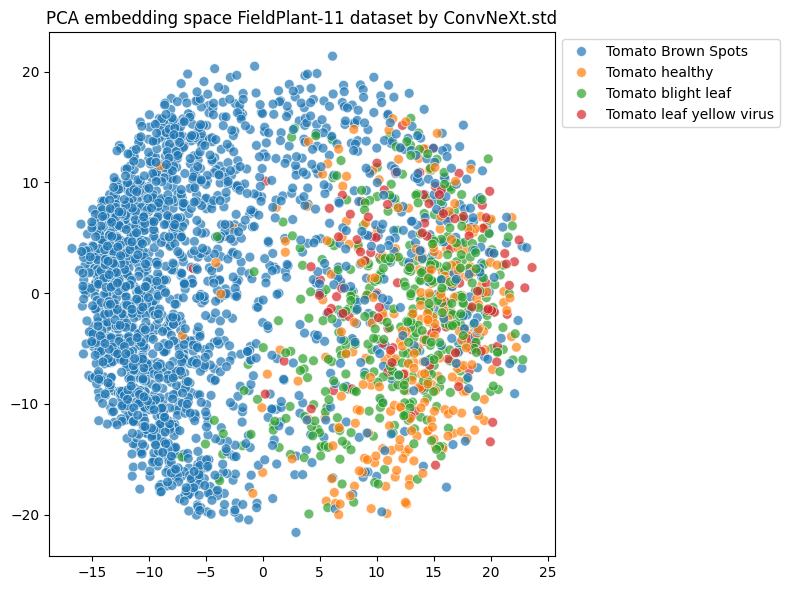

In [ ]:
# PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Giảm chiều bằng PCA hoặc t-SNE
# X = np.array(embeddings_np) # turn list => array (n_samples, n_features)
print(embeddings_np.shape)
pca = PCA(n_components=3) # n_components <= min(n_samples, n_features)
X_reduced = pca.fit_transform(embeddings_np) # n_features => 2 features,

# Vẽ
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7)
plt.title(f"PCA embedding space {data_name} dataset by {model_name}")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Vẽ PCA 3D
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)  # array of ints

# Dùng label_ids để vẽ màu
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
    c=label_ids,
    cmap='tab10',
    s=50,
    alpha=0.7
)

# Gắn tên class tương ứng với màu
legend_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             label=cls, markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
                             markersize=8)
                  for i, cls in enumerate(legend_labels)]

ax.set_title(f"PCA 3D embedding of {data_name} dataset by {model_name}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

/home/icnlab/anaconda3/envs/aiot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/icnlab/anaconda3/envs/aiot/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


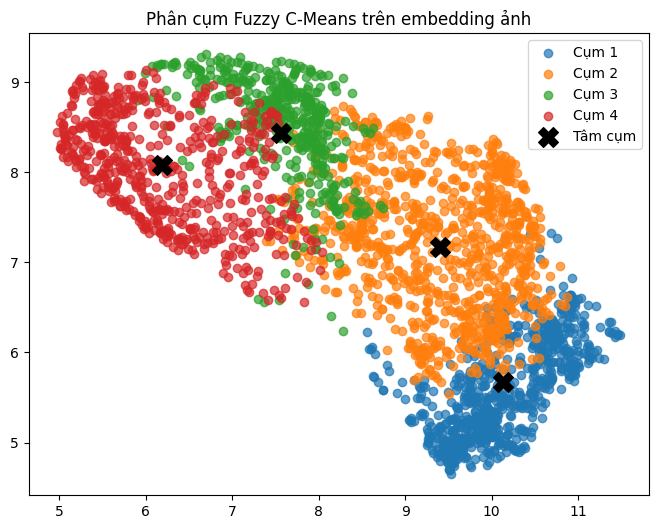

In [34]:
# FCM 1
import skfuzzy as fuzz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
n_clusters = len(np.unique(y_encoded))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings_np)
umap_model = umap.UMAP(n_components=4, random_state=42)
X_reduced = umap_model.fit_transform(X_scaled)
# Transpose input cho FCM (shape: [features, samples])
data = X_reduced.T

# Áp dụng FCM
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None)

# Lấy nhãn cụm có xác suất cao nhất
cluster_labels = np.argmax(u, axis=0)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_clusters):
    ax.scatter(
        X_reduced[cluster_labels == i, 0],
        X_reduced[cluster_labels == i, 1],
        label=f'Cụm {i+1}', alpha=0.7
    )

# Vẽ tâm cụm
ax.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, c='black', label='Tâm cụm')
ax.legend()
ax.set_title('Phân cụm Fuzzy C-Means trên embedding ảnh')
plt.show()

In [36]:
# evaluate fuzy
from collections import Counter
import numpy as np
from sklearn.metrics import silhouette_samples

def evaluate_clusters_performance(true_labels, cluster_labels, embeddings, certainty_scores=None):
    true_labels = np.array(true_labels)
    cluster_labels = np.array(cluster_labels)
    embeddings = np.array(embeddings)

    unique_clusters = np.unique(cluster_labels)
    sil_samples = silhouette_samples(embeddings, cluster_labels)
    results = {}

    for cluster in unique_clusters:
        idx = np.where(cluster_labels == cluster)[0]
        labels_in_cluster = true_labels[idx]
        sil_in_cluster = sil_samples[idx]
        purity = Counter(labels_in_cluster).most_common(1)[0][1] / len(idx)

        result = {
            'size': len(idx),
            'purity': purity,
            'silhouette': float(np.mean(sil_in_cluster)) if len(idx) > 1 else None,
        }

        if certainty_scores is not None:
            certs = certainty_scores[idx]
            result['mean_certainty'] = float(np.mean(certs))

        results[cluster] = result
    return results

# embeddings: là X_reduced
# cluster_labels: np.argmax(u, axis=0)
# certainty_scores: np.max(u, axis=0)

cluster_labels = np.argmax(u, axis=0)  # nhãn cụm
certainty_scores = np.max(u, axis=0)  # độ chắc chắn của mỗi điểm

cluster_eval = evaluate_clusters_performance(
    true_labels=labels,
    cluster_labels=cluster_labels,
    embeddings=X_reduced,
    certainty_scores=certainty_scores
)

# In kết quả
for cid, info in cluster_eval.items():
    print(f"Cluster {cid}:")
    print(f"  Size: {info['size']}")
    print(f"  Purity: {info['purity']:.4f}")
    print(f"  Silhouette: {info['silhouette']:.4f}" if info['silhouette'] is not None else "  Silhouette: N/A")
    print(f"  Mean Certainty: {info['mean_certainty']:.4f}")


Cluster 0:
  Size: 734
  Purity: 0.9360
  Silhouette: 0.4187
  Mean Certainty: 0.7294
Cluster 1:
  Size: 981
  Purity: 0.9817
  Silhouette: 0.4044
  Mean Certainty: 0.7110
Cluster 2:
  Size: 452
  Purity: 0.4558
  Silhouette: 0.3089
  Mean Certainty: 0.6670
Cluster 3:
  Size: 598
  Purity: 0.4147
  Silhouette: 0.3735
  Mean Certainty: 0.7298
